This notebook is part of the SelfiSys project and is licensed under the GNU General Public License v3.0 or later (GPL-3.0-or-later). See the accompanying LICENSE file or visit [GNU GPL](https://www.gnu.org/licenses/gpl-3.0.en.html) for details.

Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

# Compute the radial selection functions

Define custom log-normal radial selection functions.

## Set up the environment and parameters

In [1]:
from selfisys.global_parameters import *

wd = Path(OUTPUT_PATH) / "expl_notebooks/selection/"

In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

from scipy.integrate import simpson
from scipy.interpolate import UnivariateSpline
from astropy.cosmology import Planck18 as cosmo
from classy import Class

from selfisys.utils.tools import cosmo_vector_to_class_dict
from selfisys.utils.plot_examples import *
from selfisys.utils.plot_utils import *
from selfisys.selection_functions import LognormalSelection

Path(wd).mkdir(parents=True, exist_ok=True)

In [3]:
L = 3.6
Lcorner = L * np.sqrt(3)

LogNorm = LognormalSelection()
one_lognormal = LogNorm.one_lognormal

def multiple_lognormal(x, ss, ll, rr):
    return LogNorm.multiple_lognormal(x, None, ss, ll, rr)

xx = np.linspace(1e-5, Lcorner, 1000)
zz = np.linspace(0, 3.1, 1200)  # Redshift range

## Central parameters for the three populations

In [4]:
means_com = np.array([0.6410, 1.9210, 2.9185])  # Arbitrary values for our mock populations

### Redshift vs comoving distance

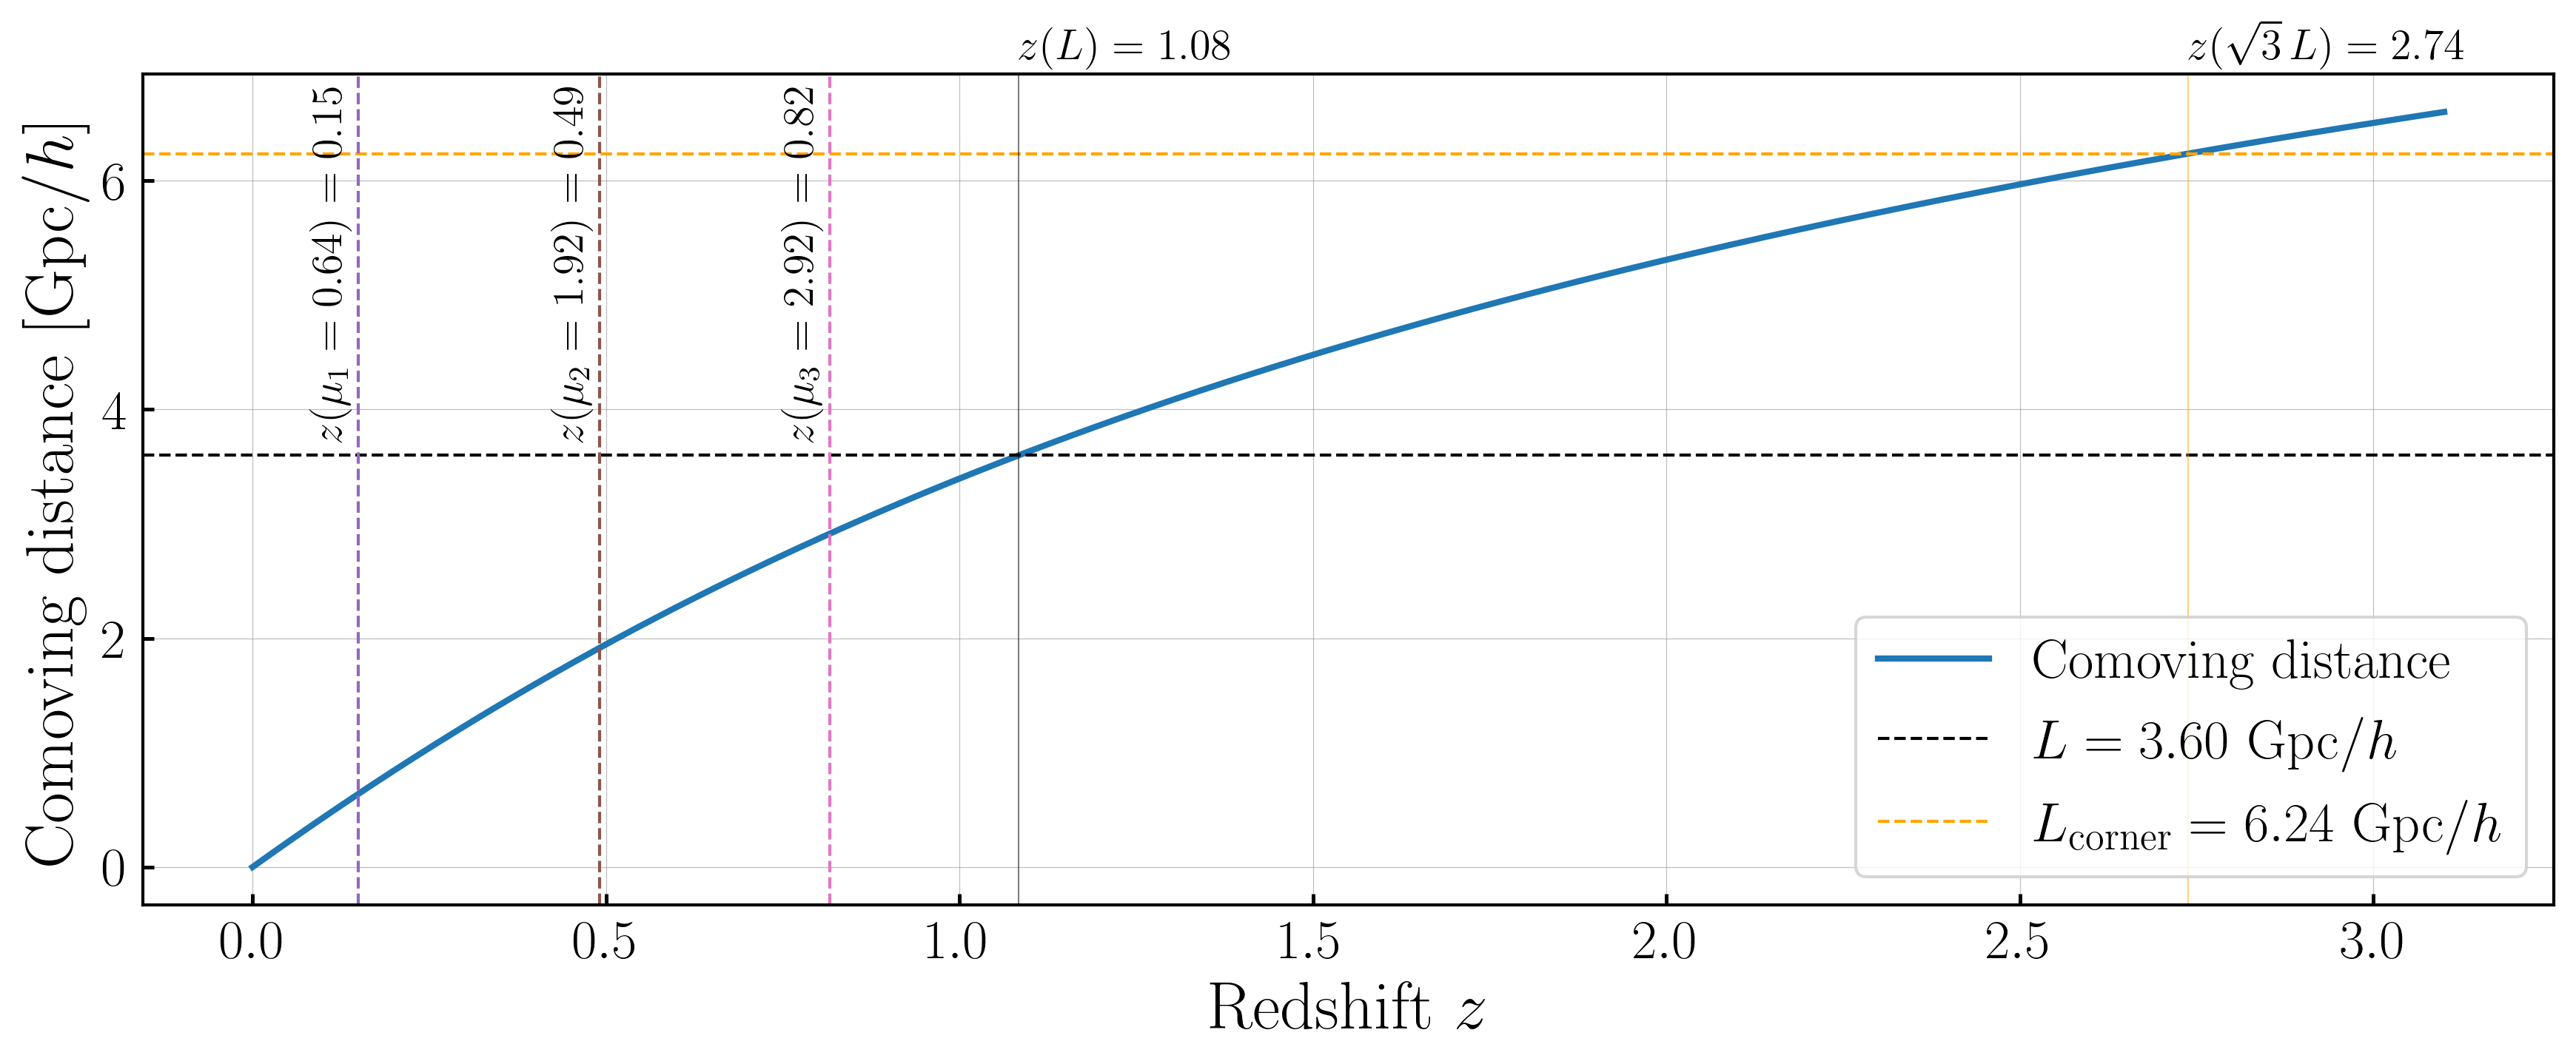

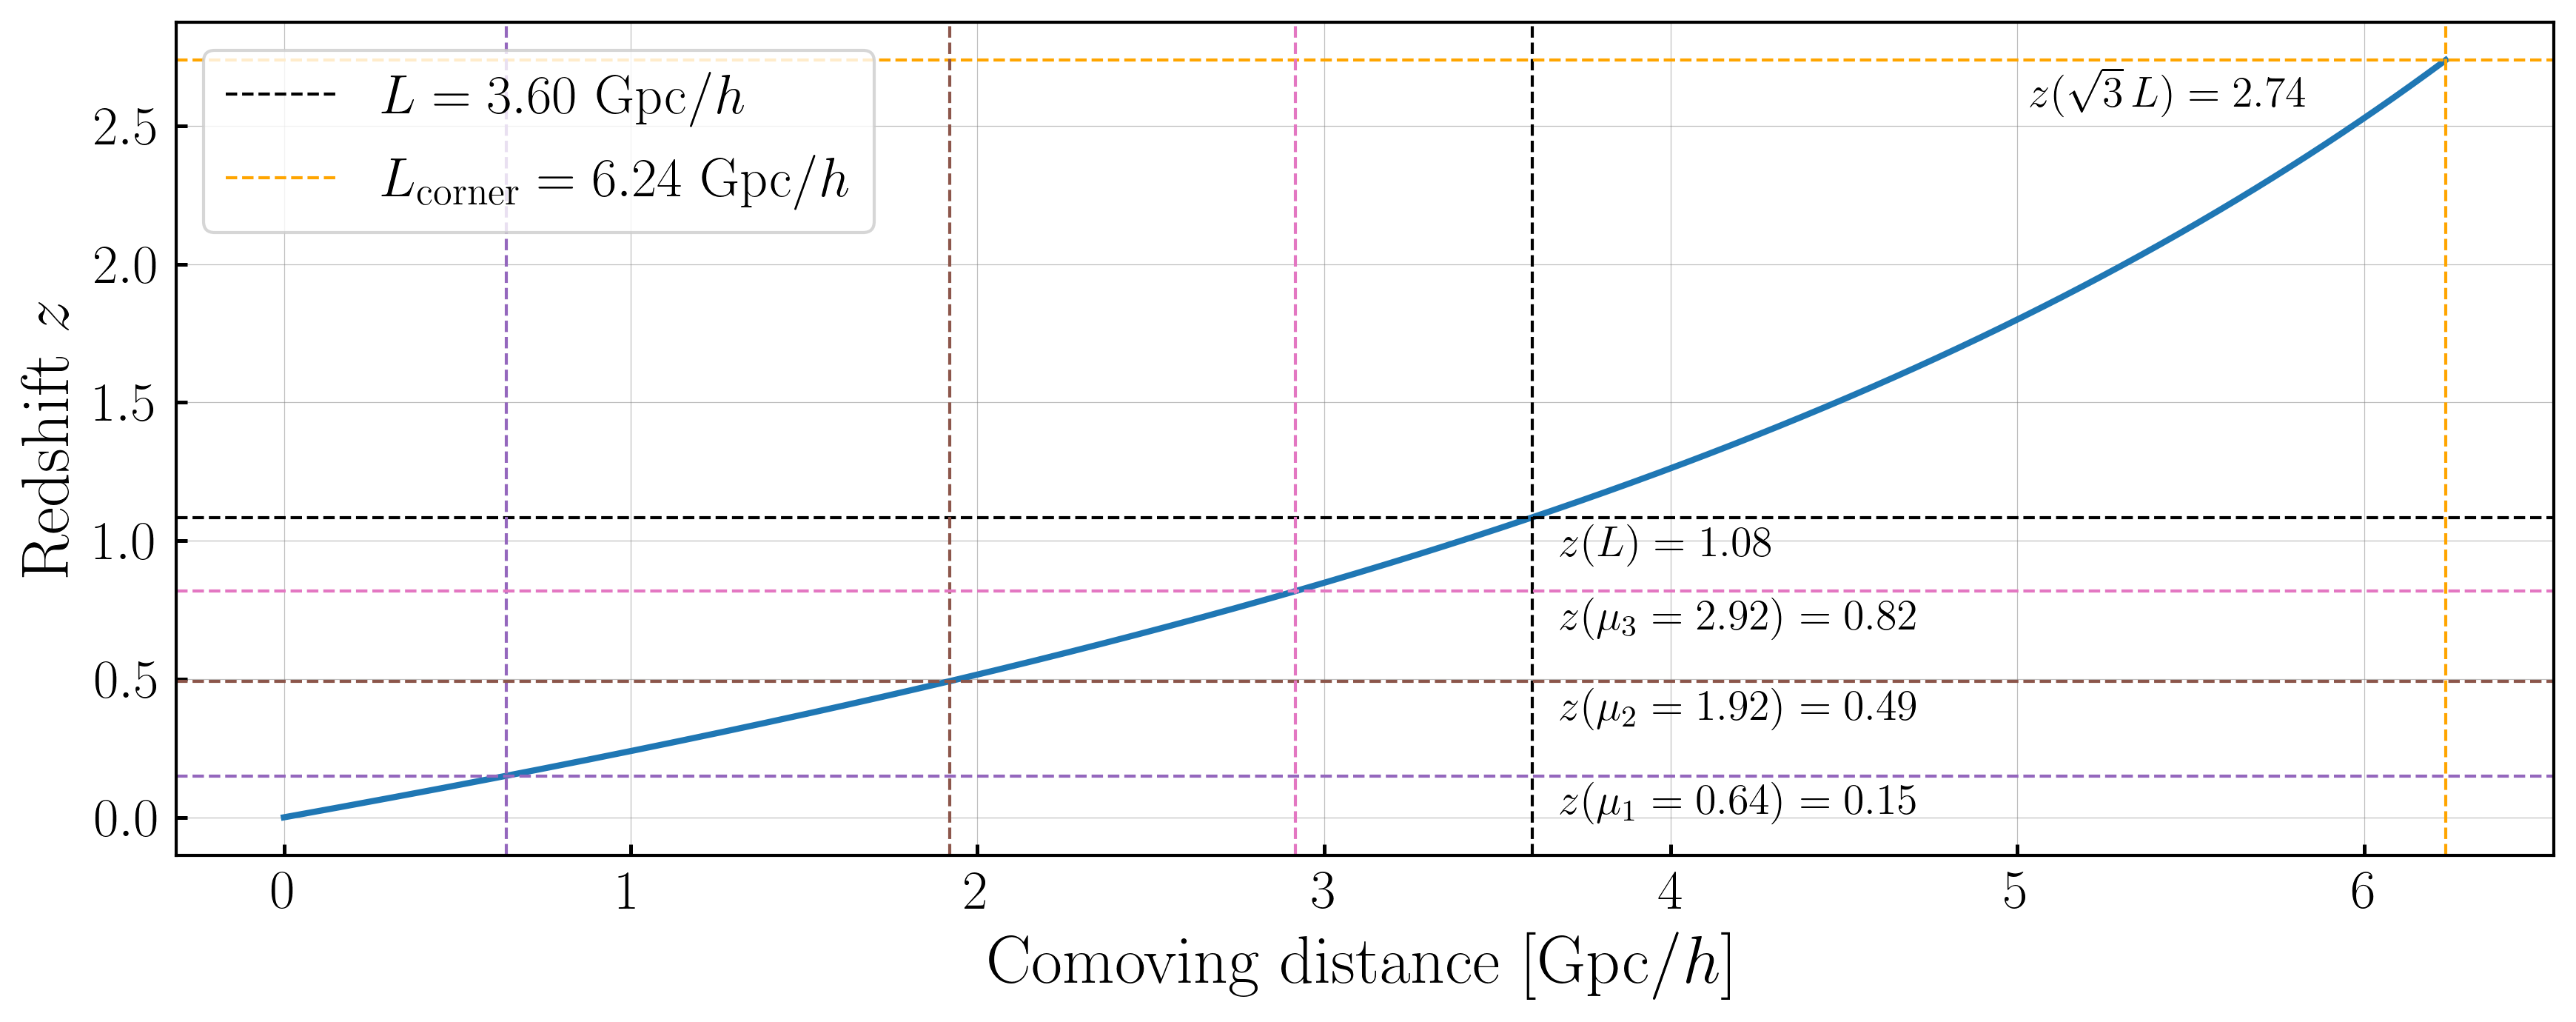

In [5]:
plot_comoving_distance_redshift(zz, cosmo, means_com, L, Lcorner, wd)
spline = redshift_distance_conversion(zz, cosmo, means_com, L, Lcorner, xx, wd)

### Linear bias model

#### For tiny $z$ (local, very late Universe)

We rely on [\[howlett2015clustering\]](https://doi.org/10.48550/arXiv.1409.3238):

> We measure Redshift-Space Distortions (RSD) in the two-point correlation function of a
sample of 63,163 spectroscopically identified galaxies with z < 0.2, an epoch where there
are currently only limited measurements, from the Sloan Digital Sky Survey (SDSS) Data
Release 7 Main Galaxy Sample. Our sample, which we denote MGS, covers 6,813 deg2 with
an effective redshift zeff = 0.15 and is described in our companion paper (Paper I), which
concentrates on BAO measurements.

Fitting their data with a $\chi^2$ distribution, they measure 
$$
f\sigma_8(z=0.15)=0.43^{+0.15}_{-0.14}
$$
and
$$
b\sigma_8(z=0.15)=1.20\pm 0.15
$$

Further assuming $f=\Omega_m^{0.55}$, we obtain:
$$
\sigma_8(z=0.15)=0.43^{+0.15}_{-0.14}\times\Omega_m^{-0.55}=0.43^{+0.15}_{-0.14}\times 0.31^{-0.55}
$$
$$
\sigma_8(z=0.15)\simeq 0.82 \implies b(z=0.15)\simeq 1.47
$$

#### For LRG bins

We rely on [\[gil2015power\]](https://doi.org/10.48550/arXiv.1407.5668):

> We analyse the anisotropic clustering of the Baryon Oscillation Spectroscopic Survey (BOSS) CMASS Data Release 11 sample, which consists of 690,827 galaxies in the redshift range 0.43 < z < 0.70 and has a sky coverage of 8498 deg2 corresponding to an effective volume of ∼ 6 Gpc3. We fit the Fourier space statistics, the power spectrum and bispectrum monopoles to measure the linear and quadratic bias parameters, b1 and b2, for a non-linear non-local bias model, the growth of structure parameter f and the amplitude of dark matter density fluctuations parametrised by σ8.

They measure $b_{z_{\textrm{eff}}}^{1.40}\sigma_8(z_{\textrm{eff}})=1.672\pm 0.060$ and $\sigma_8(z_{\textrm{eff}})=0.597$, $z_{\textrm{eff}}=0.57$, so we get $b_{z_{\textrm{eff}}}^{1.40}=2.80\pm 0.10$.

In [6]:
2.80**(1/1.40)

2.0864048990680044

Assuming $b(z)D(z)$ to be constant in the redshift range of interest, we obtain $b(z) \simeq \dfrac{b_{z_{eff}}\times D(z_{\text{eff}})}{D(z)} \simeq \dfrac{2.086\times D(z_{\text{eff}})}{D(z)}$.

In [7]:
# Compute the linear growth factor with CLASS
cosmo_dict = cosmo_vector_to_class_dict(planck_mean)
Cosmology = Class()
Cosmology.set(cosmo_dict)
Cosmology.compute()
Dz = Cosmology.get_background()["gr.fac. D"]
redshifts = Cosmology.get_background()["z"]
Cosmology.struct_cleanup()
Cosmology.empty()

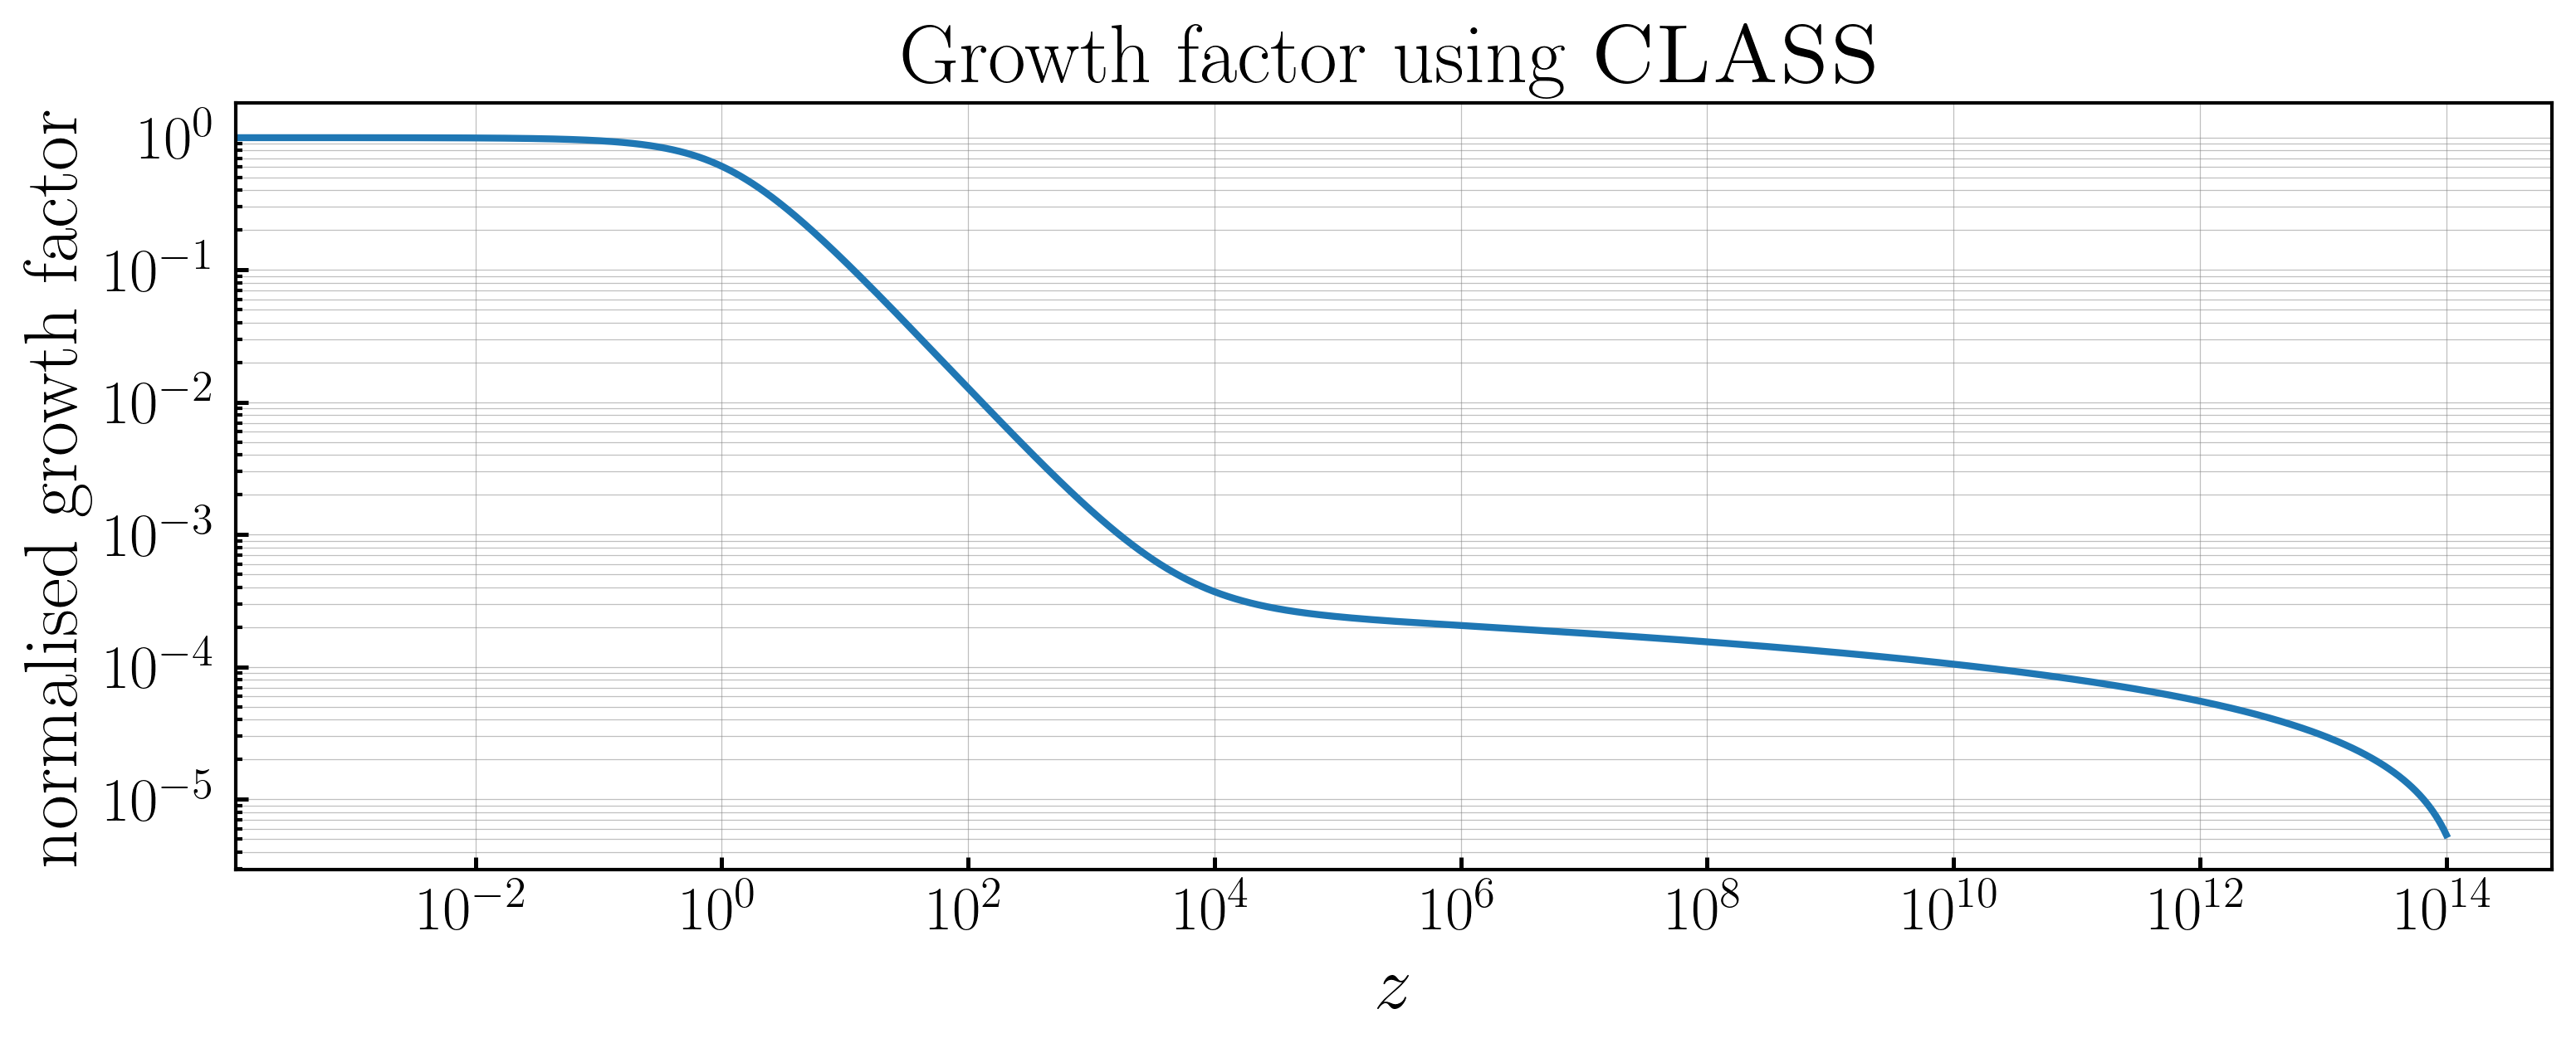

In [8]:
plt.figure(figsize=(12, 4))
plt.loglog(redshifts, Dz)
plt.xlabel(r"$z$")
plt.ylabel("normalised growth factor")
plt.grid(which="both", axis="both", linestyle="-", linewidth=0.3, color="gray", alpha=0.5)
plt.title(r"Growth factor using \textsc{CLASS}")
plt.show()

In [9]:
z_means = np.round(spline(means_com), 4)
print(z_means)

[0.15   0.4925 0.8182]


In [10]:
np.random.seed(1100)
z_eff = 0.57
z_eff_index = np.argmin(np.abs(redshifts - z_eff))
growth_factor_z_eff = Dz[z_eff_index]
print("growth_factor_z_eff =", growth_factor_z_eff)
b_zeff = np.round(2.80 ** (1 / 1.40) + 0.02 * np.random.uniform(-1, 1), 2)
print("b_zeff =", b_zeff)
print("numerator b(z): {}".format(b_zeff * growth_factor_z_eff))
for z_mean in z_means[1:]:
    bias = b_zeff * growth_factor_z_eff / Dz[np.argmin(np.abs(redshifts - z_mean))]
    bias += 0.02 * np.random.uniform(-1, 1)
    print(
        "b({})={:.2f}".format(
            z_mean,
            bias,
        )
    )

growth_factor_z_eff = 0.7433515577264593
b_zeff = 2.07
numerator b(z): 1.5387377244937708
b(0.4925)=1.99
b(0.8182)=2.32


$$
b(z) \simeq \frac{2.086\times D(z_{\text{eff}})}{D(z)} \simeq \frac{1.54}{D(z)}
$$

## Toy model: lognormal distributions with respect to comoving distance

### Utilities

In [11]:
def integrate(x, res, res_mis=None):
    """
    Compute the numerical integral of given data arrays using Simpson's
    rule.

    Parameters
    ----------
    x : array-like
        The x-axis values for integration.
    res : list of array-like
        A list of y-axis values to integrate over the x-axis.
    res_mis : list of array-like, optional
        A list of y-axis values to integrate over the x-axis, for the
        misspecified model. Default is None.

    Returns
    -------
    tuple
        - intes: list of float
            The integrated values for res.
        - intes_mis: list of float or None
            The integrated values for res_mis if provided,
            None otherwise.
    """

    intes = []
    for i, y in enumerate(res):
        integral = simpson(y, x=x)
        intes.append(integral)
        print(f"Integral of R_{i+1}(r): {integral:.4f}")
    total_res = np.sum(intes)
    print(f"Total: {total_res:.4f}")

    if res_mis is not None:
        intes_mis = []
        for i, y_mis in enumerate(res_mis):
            integral_mis = simpson(y_mis, x=x)
            intes_mis.append(integral_mis)
            print(f"Integral of R_{i+1}(r): {integral_mis:.4f}")
        total_mis = np.sum(intes_mis)
        print(f"Total: {total_mis:.4f}")
    else:
        intes_mis = None

    return intes, intes_mis

In [12]:
print("Means (comoving distance) of the 3 populations = ", means_com)
print("Means (redshift) of the 3 populations = ", z_means)

Means (comoving distance) of the 3 populations =  [0.641  1.921  2.9185]
Means (redshift) of the 3 populations =  [0.15   0.4925 0.8182]


### Standard deviations for the three populations

In [13]:
cste = 0.1
std1 = cste * (1+z_means[0])
std2 = cste * (1+z_means[1])
std3 = cste * (1+z_means[2])
stds = np.array([std1, std2, std3])
print("Standard deviations for the 3 populations:", stds)

Standard deviations for the 3 populations: [0.115   0.14925 0.18182]


### Corresponding lognormal distribution parameters

In [14]:
mus = np.log(means_com**2 / np.sqrt(means_com**2 + stds**2))
sig2s = np.log(1 + stds**2 / means_com**2)
modes = np.exp(mus - sig2s)
d_np = (cosmo.comoving_distance(zz) / 1e3).value
z_modes = np.array([zz[np.argmin(np.abs(d_np - mode))] for mode in modes])
print("Modes (z) of the 3 populations:", np.round(z_modes, 6))

Modes (z) of the 3 populations: [0.142202 0.486072 0.811843]


In [15]:
print(cste * (1 + z_modes))

[0.11422018 0.14860717 0.18118432]


### Lognormal distributions

params: [array([0.115  , 0.14925, 0.18182]), array([0.641 , 1.921 , 2.9185]), [1, 1, 1]]
[20:43:31|INFO      ]|(selfisys.utils.plot_utils) Plotting selection functions...


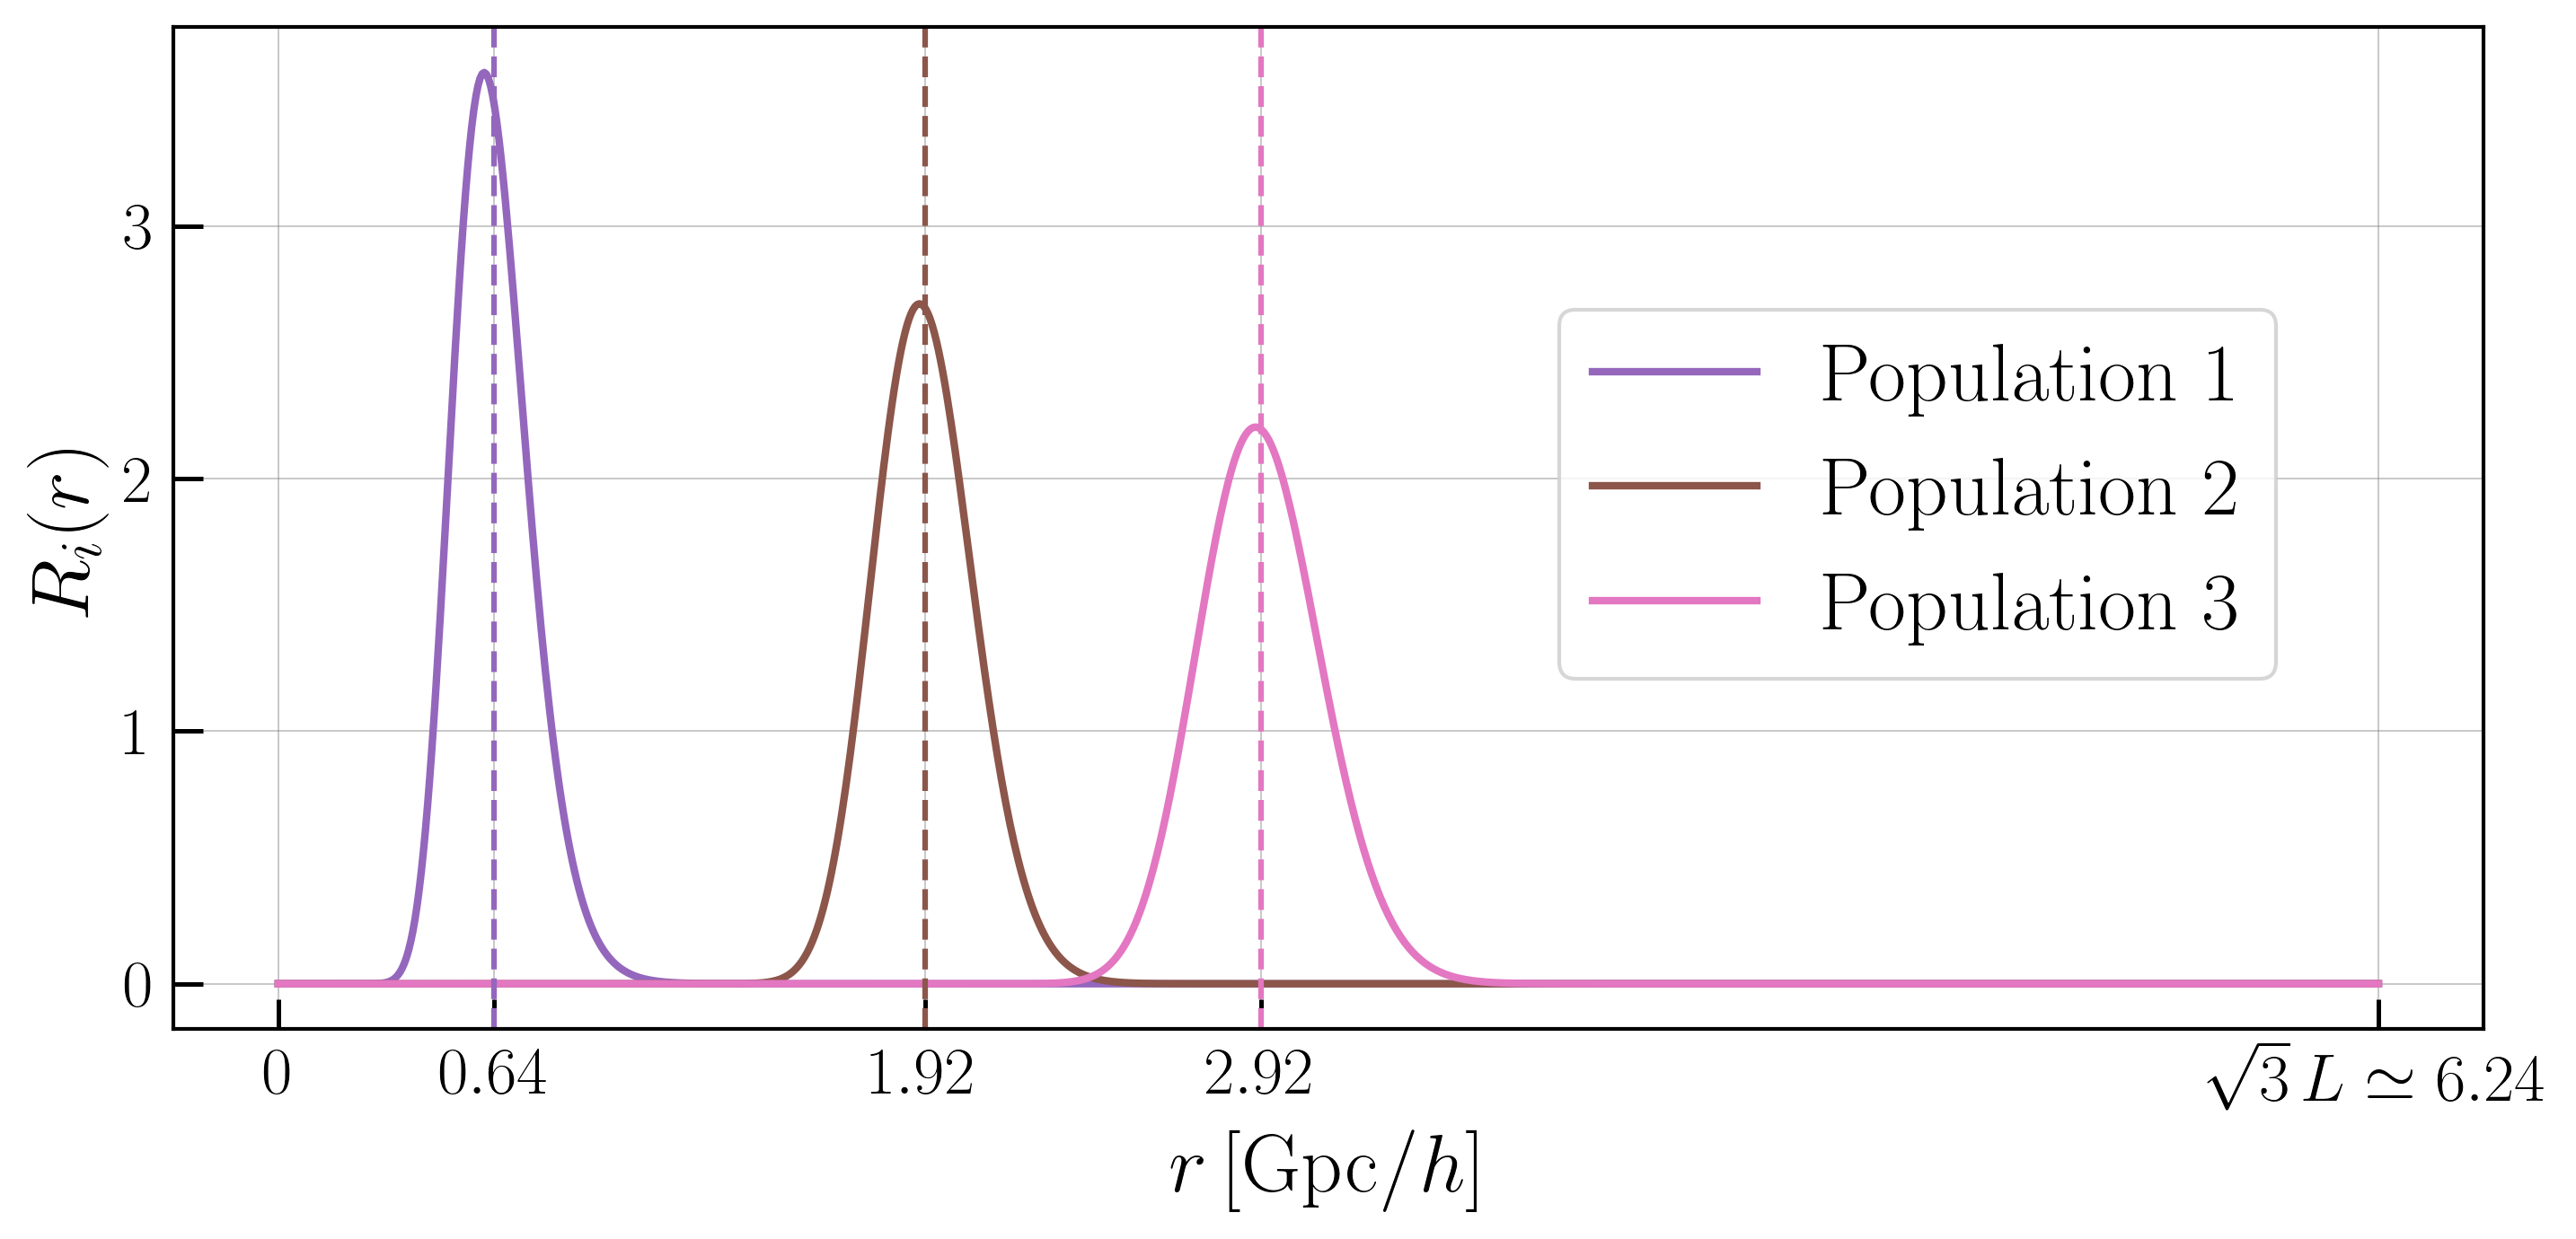

Integral of R_1(r): 0.2778
Integral of R_2(r): 0.2778
Integral of R_3(r): 0.2778
Total: 0.8333


In [16]:
max1 = np.max(one_lognormal(xx, std1, means_com[0]))
max2 = np.max(one_lognormal(xx, std2, means_com[1]))
max3 = np.max(one_lognormal(xx, std3, means_com[2]))
rescale = np.max([max1, max2, max3])

params = [stds, means_com, [1, 1, 1]]
# Alternatively, one can rescale the selection functions using:
# params = [stds, means_com, [1/rescale, 1/rescale, 1/rescale]]
print("params:", params)
res = multiple_lognormal(xx, params[0], params[1], params[2])
plot_selection_functions(xx, res, None, params, L, np.sqrt(3) * L)
intes, _ = integrate(xx / L, res)

## Actual selection functions

To account for lightcone effects in the data model, we use three snapshots of the final overdensity fields, each corresponding to a central redshift associated with a specific selection function. For consistency, the selection functions are defined as lognormal distributions with respect to redshift, $z$, rather than comoving distance, $r$.

We construct the mock selection functions as follows:
1.	Define three rescaled lognormal distributions in redshift space, each characterised by a given mean (in $z$) and variance (in $z$).
2.	Define three misspecified lognormal distributions by ensuring that the sum of their integrals matches that of the well-specified functions.
3.	Convert these lognormal distributions to functions of comoving distance.

In [17]:
d_np = cosmo.comoving_distance(zz).value / 1e3
z_corner = zz[np.argmin(np.abs(d_np - Lcorner))]
z_L = zz[np.argmin(np.abs(d_np - L))]

In [18]:
zs = np.linspace(0.0001, z_corner, 1000)

In [19]:
cste_z = 0.1
std1_z = cste_z * (1 + z_means[0])
std2_z = cste_z * (1 + z_means[1])
std3_z = cste_z * (1 + z_means[2])
stds_z = np.array([std1_z, std2_z, std3_z])
print("Means (in redshift) of the 3 populations = ", z_means)
print("standard deviations for the 3 populations = ", stds_z)

mus_z = np.log(z_means**2 / np.sqrt(z_means**2 + stds_z**2))
sig2s_z = np.log(1 + stds_z**2 / z_means**2)
modes_z = np.exp(mus_z - sig2s_z)
print("Modes (in redshift) of the 3 populations = ", np.round(modes_z, 4))

Means (in redshift) of the 3 populations =  [0.15   0.4925 0.8182]
standard deviations for the 3 populations =  [0.115   0.14925 0.18182]
Modes (in redshift) of the 3 populations =  [0.075  0.4317 0.7611]


### Lognormals in redshift

[20:43:32|INFO      ]|(selfisys.utils.plot_utils) Plotting selection functions...


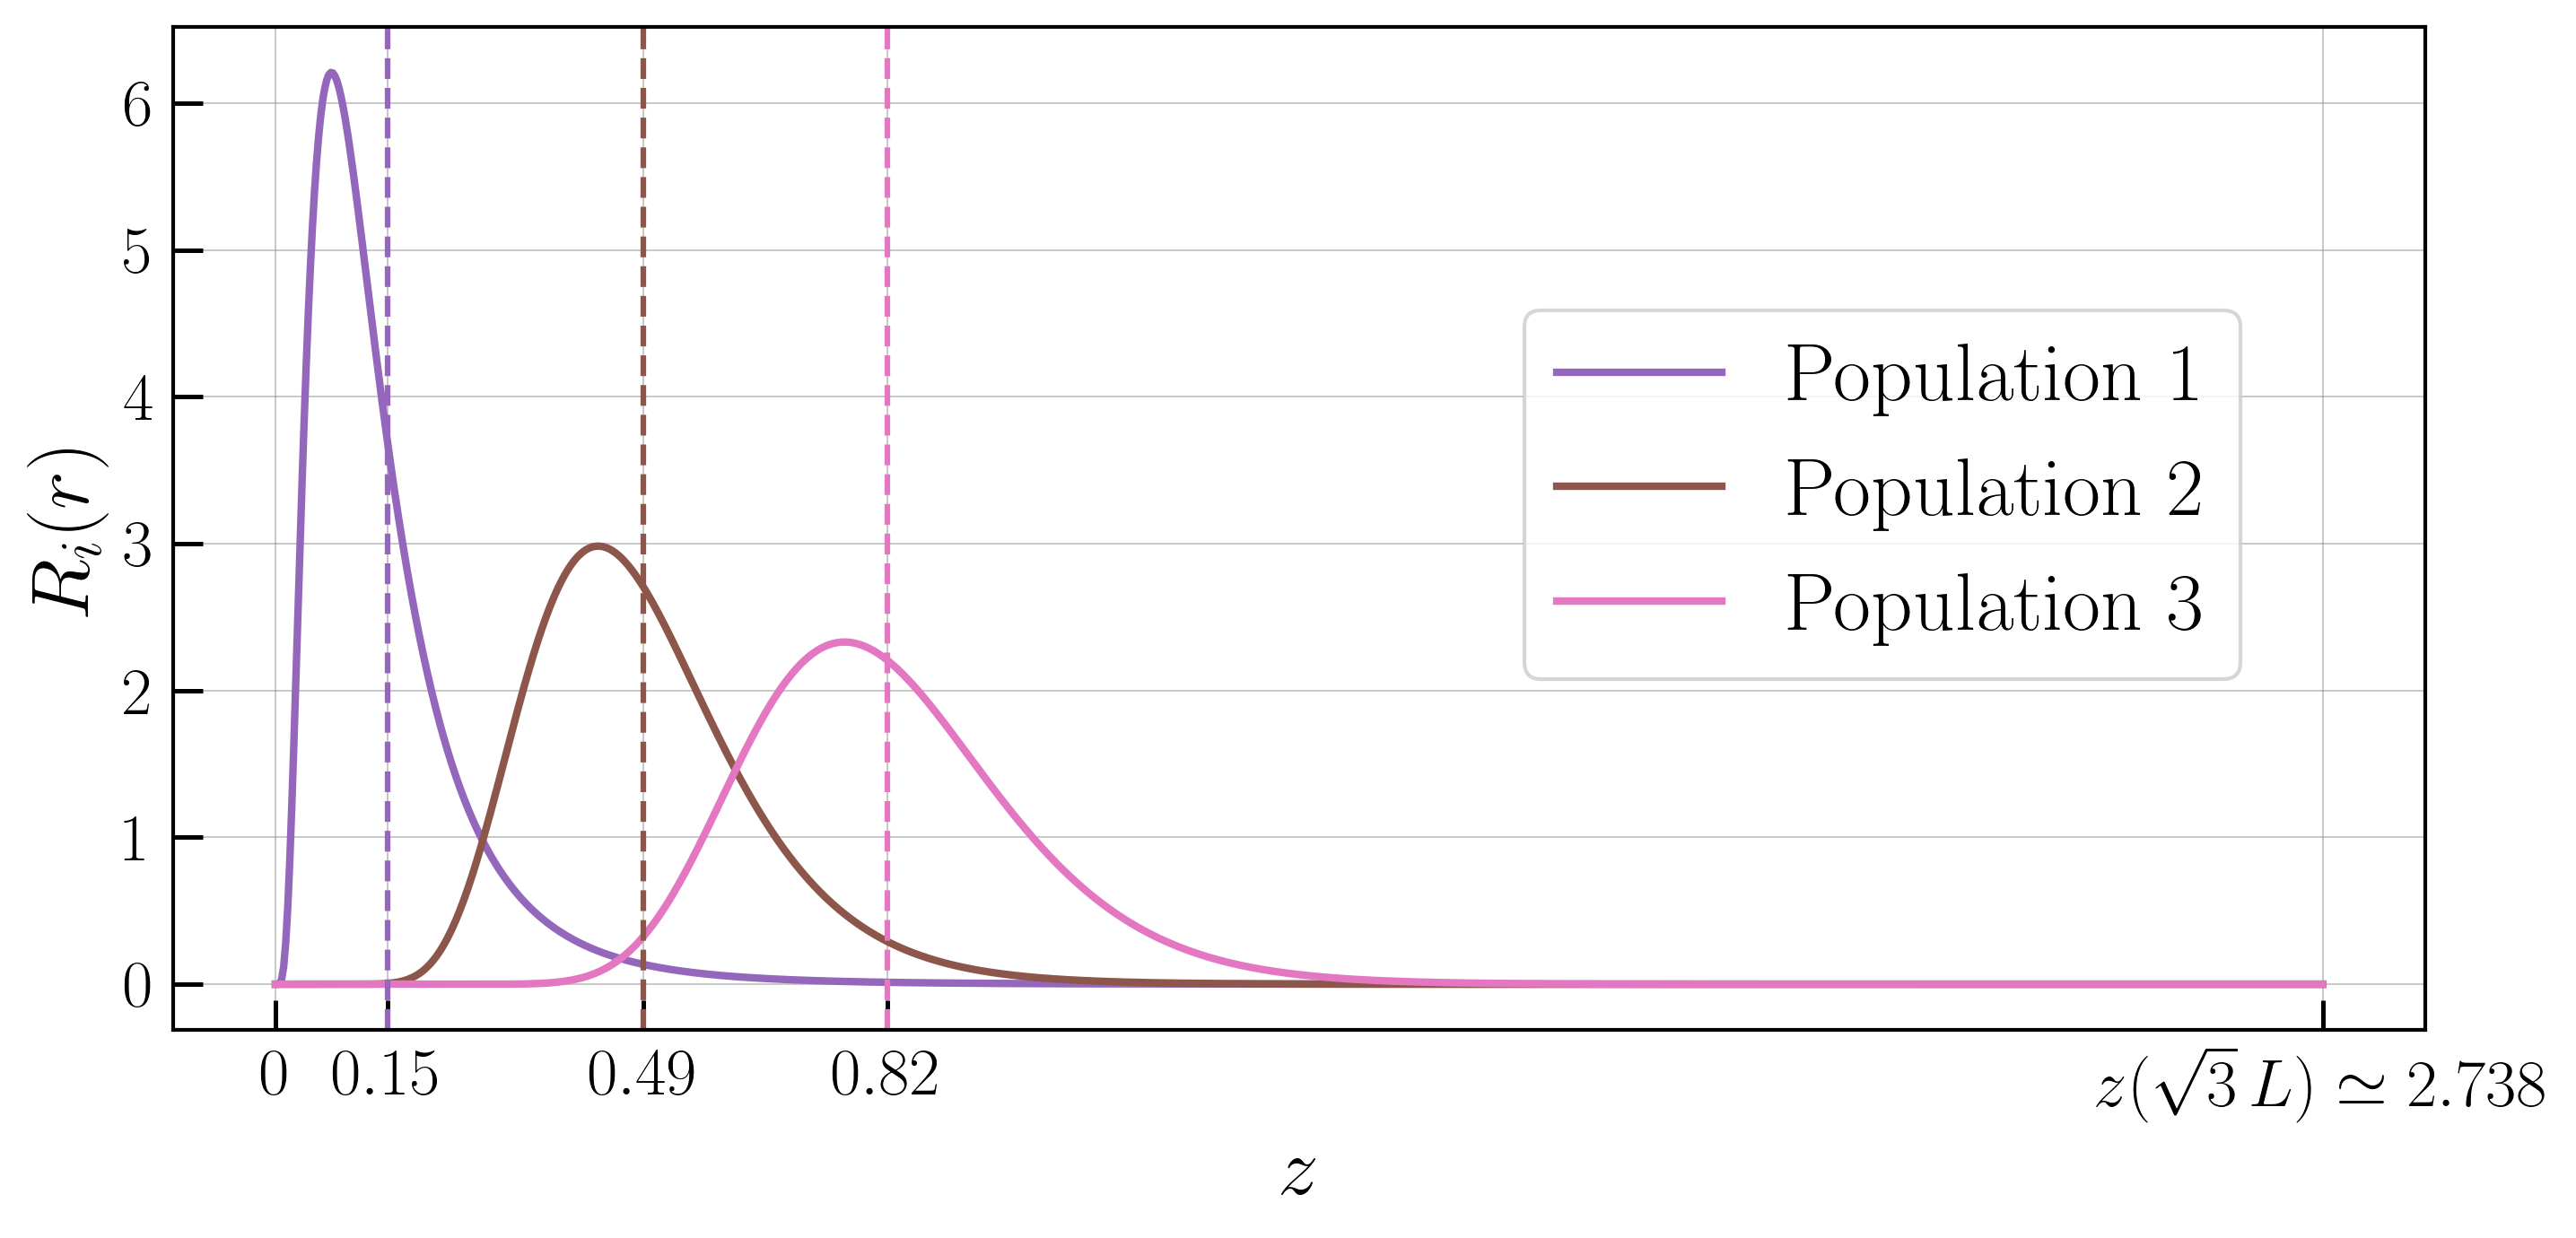

In [20]:
max1 = np.max(one_lognormal(zs, std1_z, z_means[0]))
max2 = np.max(one_lognormal(zs, std2_z, z_means[1]))
max3 = np.max(one_lognormal(zs, std3_z, z_means[2]))
rescale = np.max([max1, max2, max3])

params = [stds_z, z_means, [1 / rescale, 1 / rescale, 1 / rescale]]
res = multiple_lognormal(zs, params[0], params[1], params[2])
plot_selection_functions(zs, res, None, params, z_L, z_corner, axis="redshift")

### Selection functions, defined as functions of redshifts

Integral of R_1(r): 0.9231
Integral of R_2(r): 0.9231
Integral of R_3(r): 0.9231
Total: 2.7693
> Well-specified parameters: [array([0.115  , 0.14925, 0.18182]), array([0.15  , 0.4925, 0.8182]), [np.float64(1.0), np.float64(1.0), np.float64(1.0)]]
> Mis-specified parameters: [array([0.115  , 0.14925, 0.18182]), array([0.15  , 0.4925, 0.8182]), [np.float64(0.9), np.float64(1.199999810418996), np.float64(0.9)]]
[20:43:32|INFO      ]|(selfisys.utils.plot_utils) Plotting selection functions...


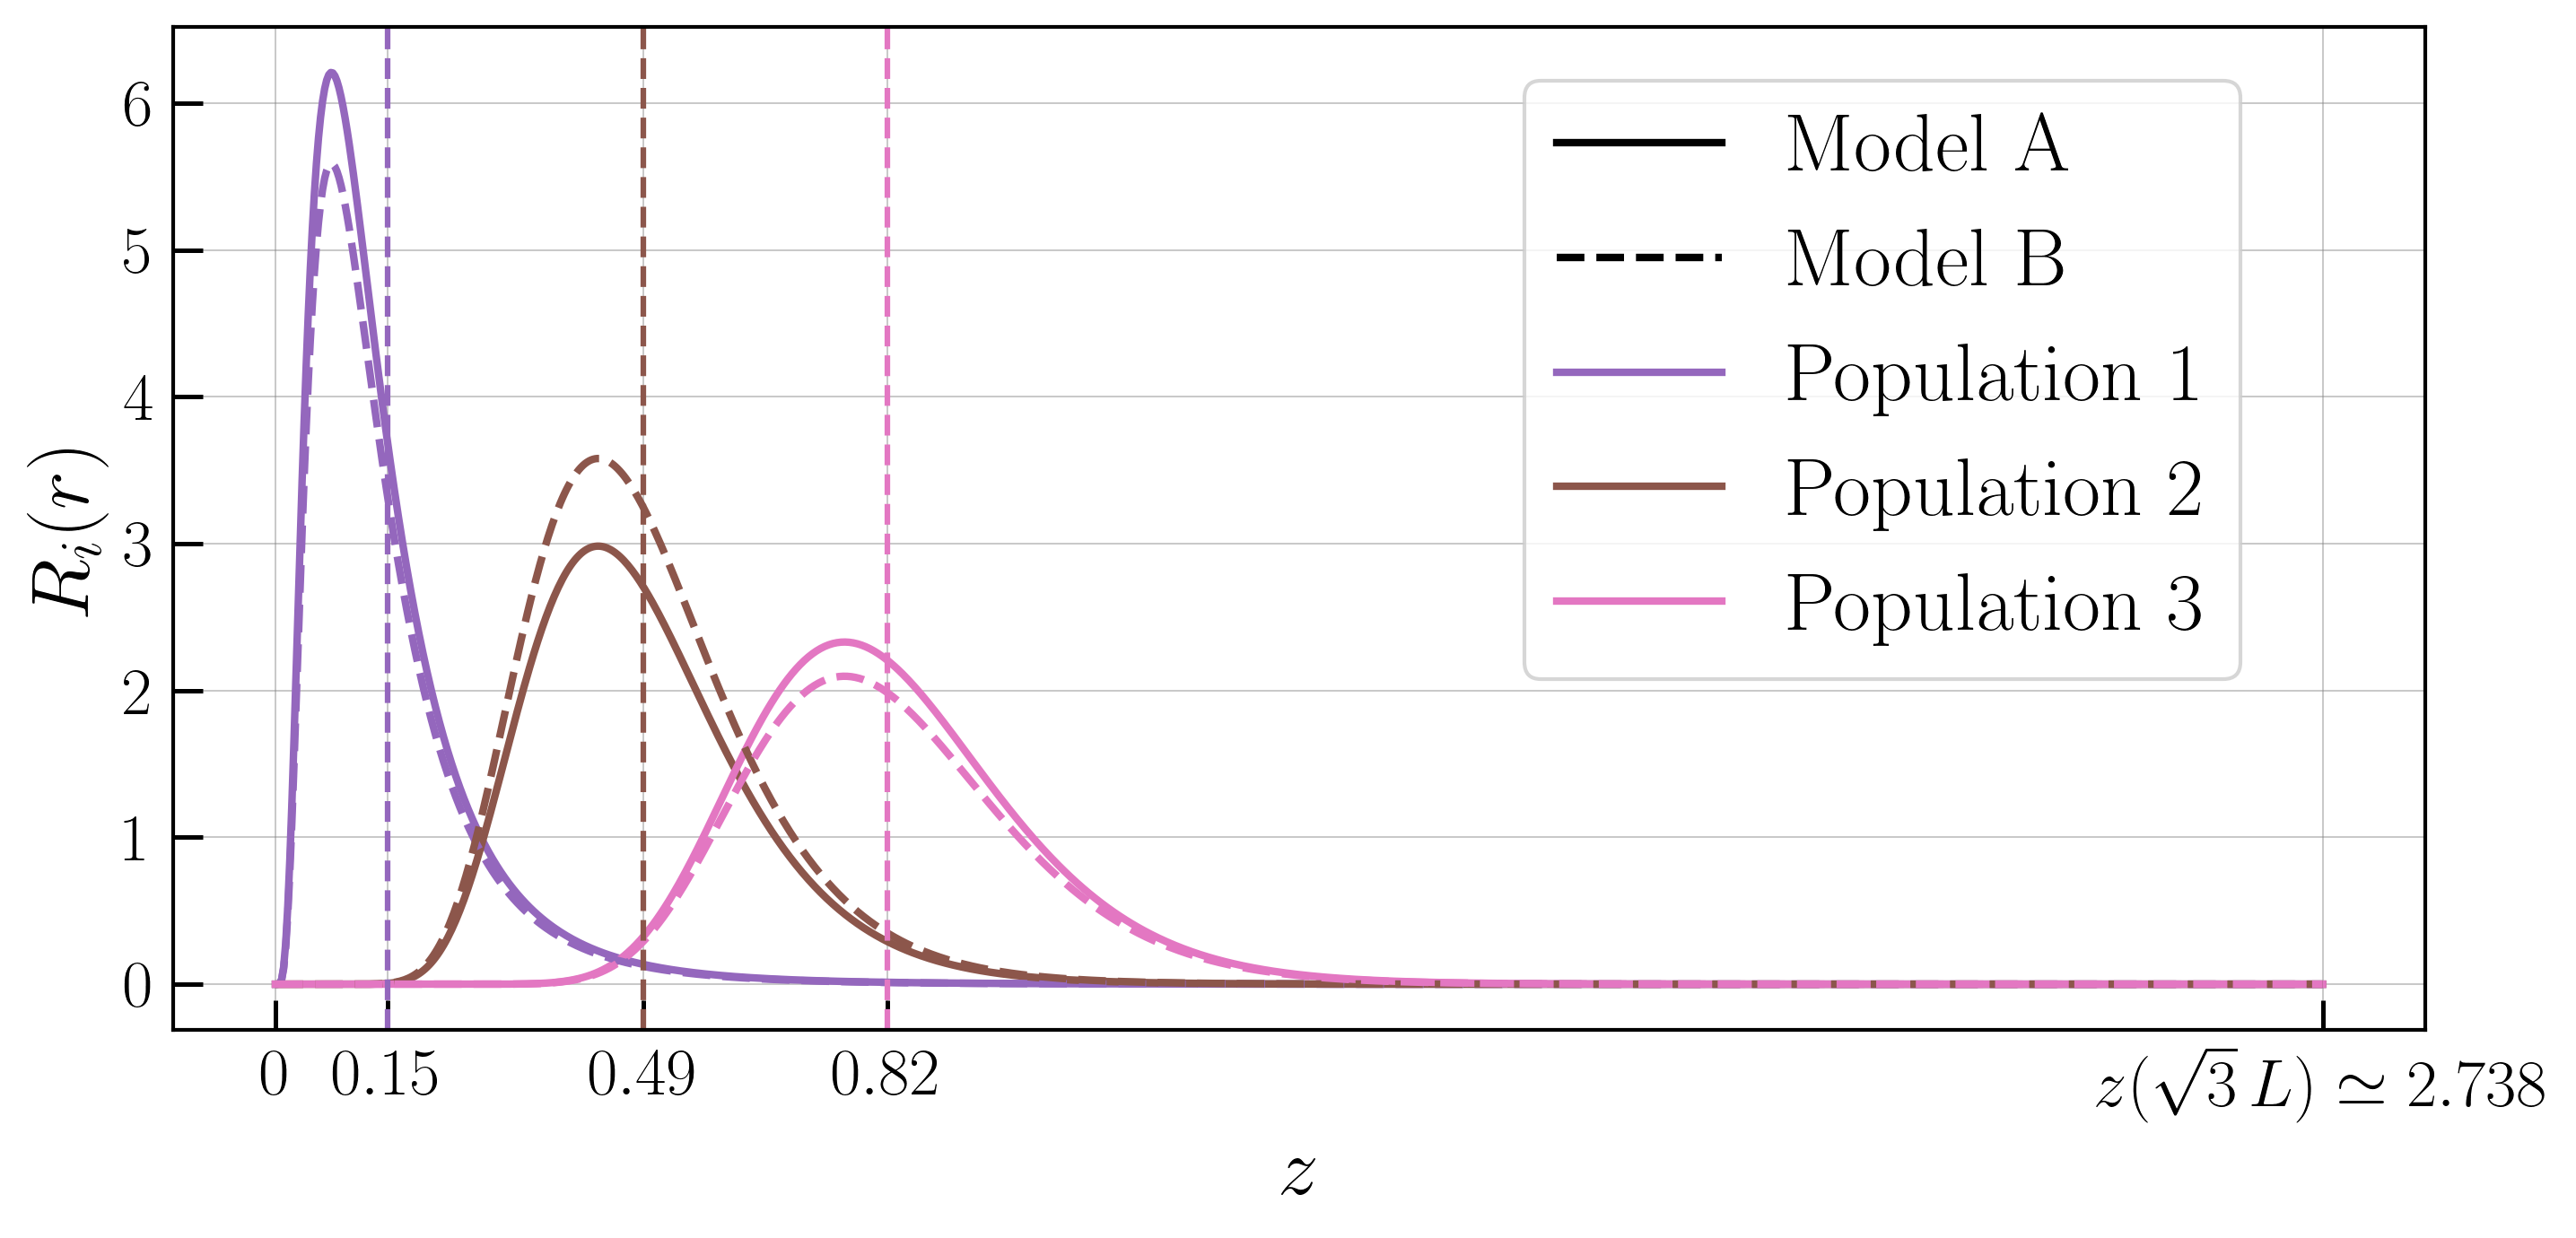

Integral of R_1(r): 0.9231
Integral of R_2(r): 0.9231
Integral of R_3(r): 0.9231
Total: 2.7693
Integral of R_1(r): 0.8308
Integral of R_2(r): 1.1077
Integral of R_3(r): 0.8308
Total: 2.7693


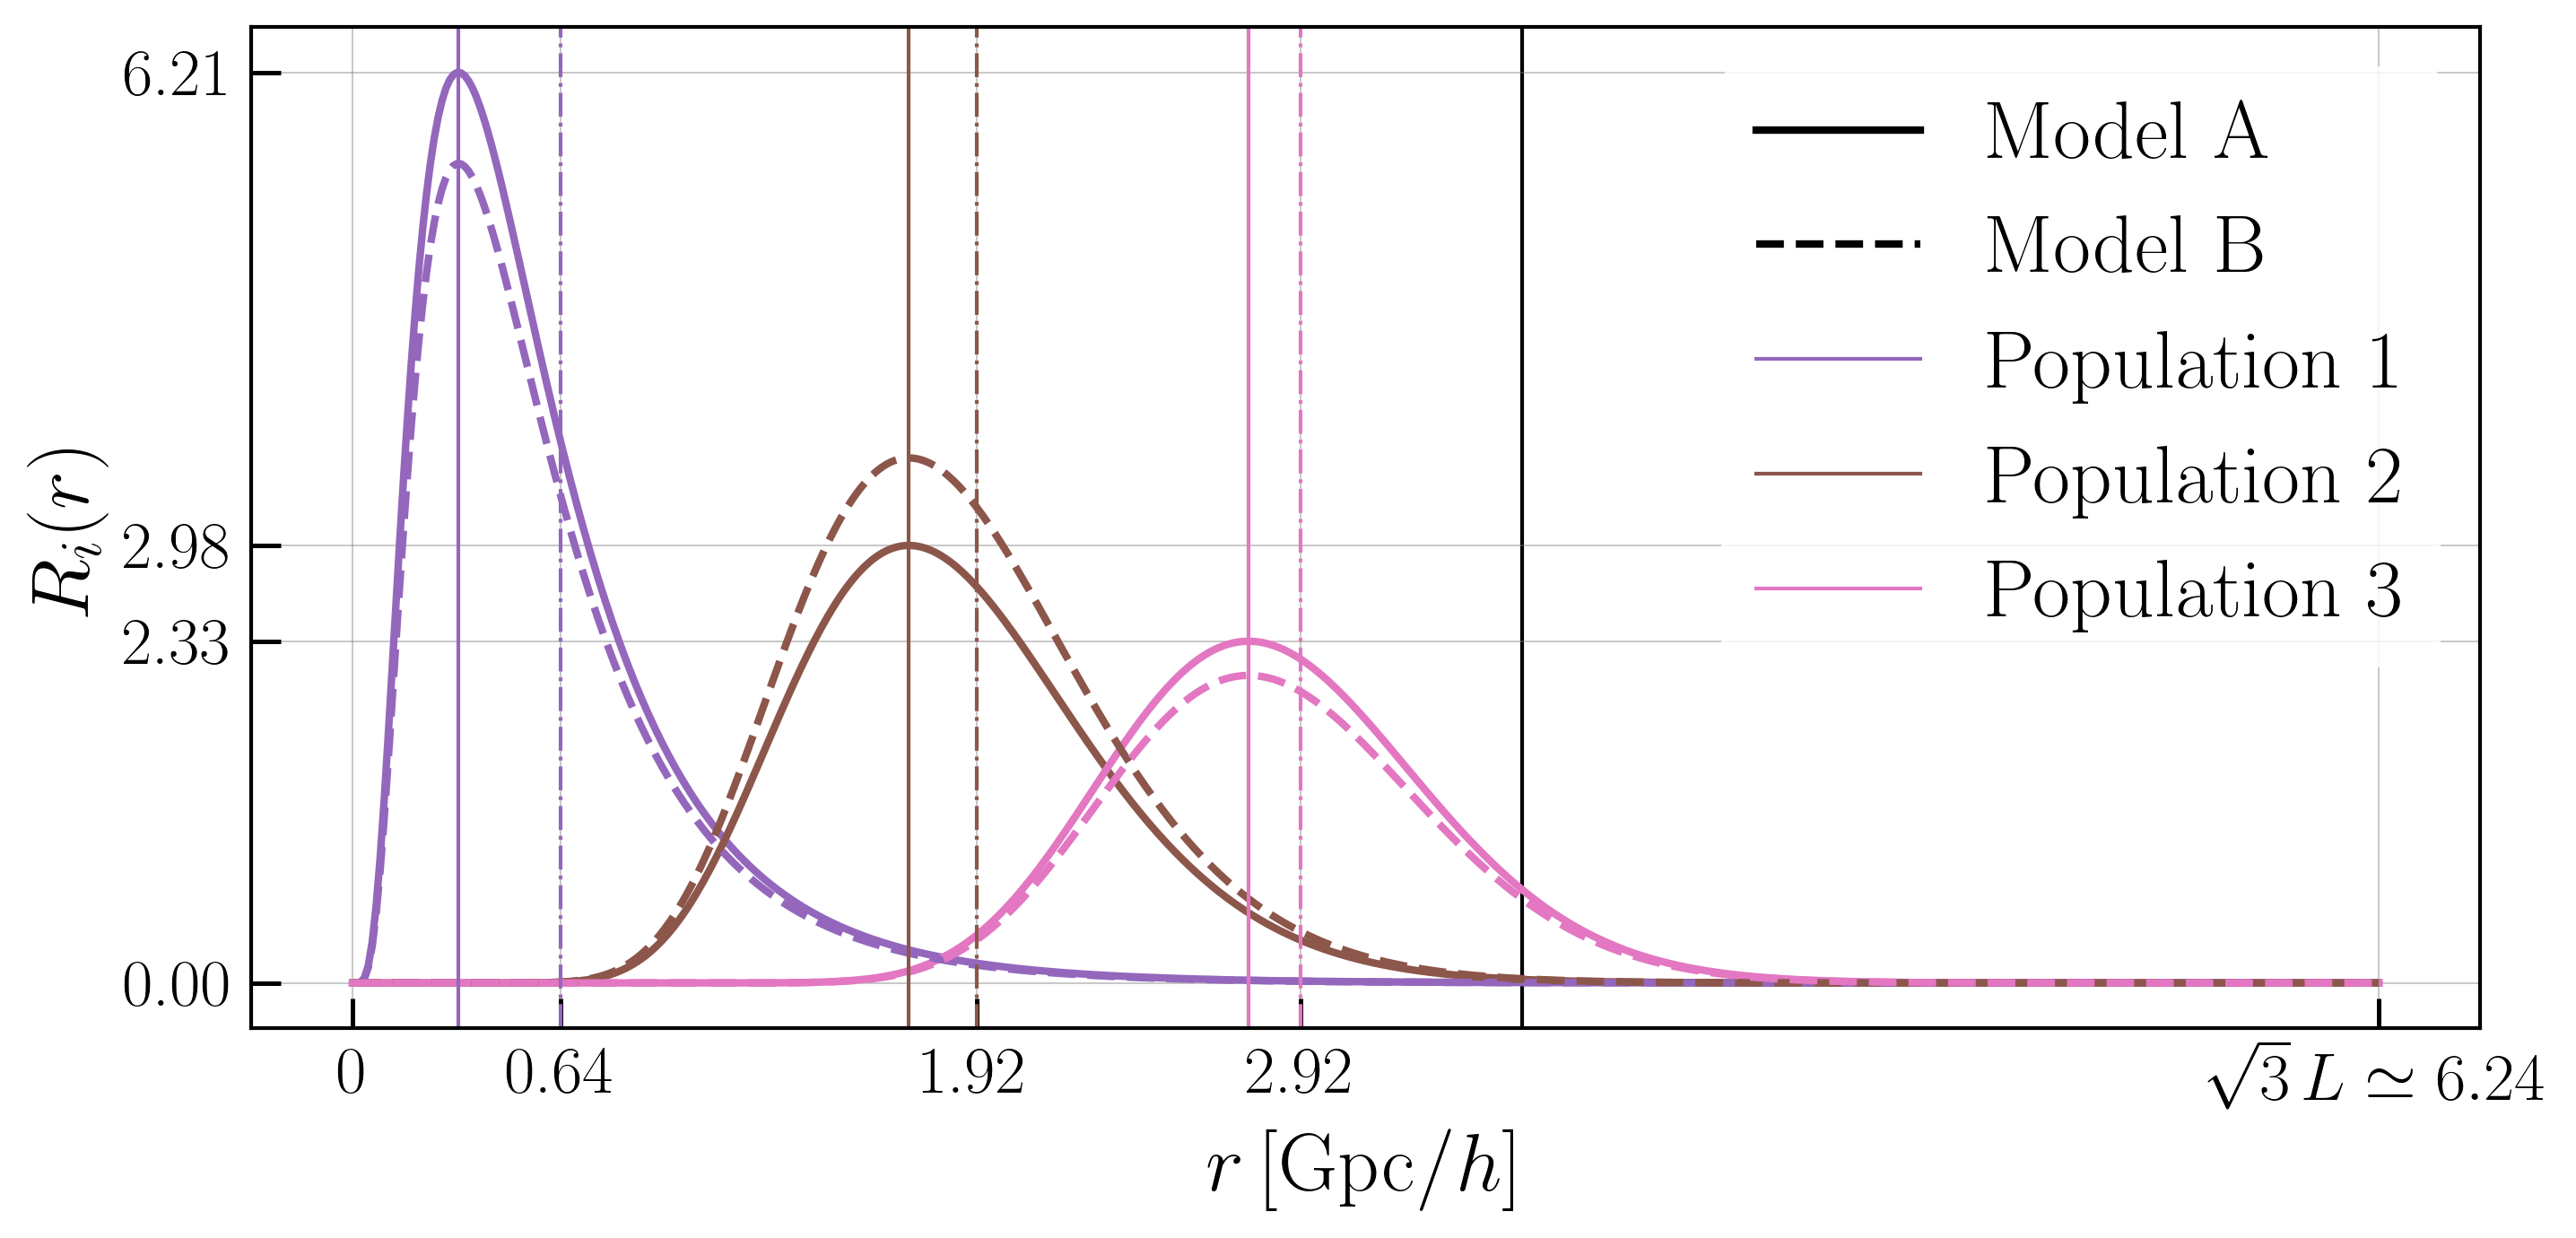

In [21]:
# Parameters for Model A
params = [stds_z, z_means, [1.0 / max1, 1.0 / max1, 1.0 / max1]]
res = multiple_lognormal(zs, params[0], params[1], params[2])

# Integrate and print the results
intes, _ = integrate(zs / z_L, res)

# Define population transfer fractions
diff_pop1 = 0.1  # Fraction of population 1 to transfer to population 2
diff_pop3 = 0.1  # Fraction of population 3 to transfer to population 2

# Compute total loss from populations 1 and 3 and adjust population 2
tot_lost = diff_pop1 * intes[0] + diff_pop3 * intes[2]  # Total loss
diff_pop2 = tot_lost / intes[1]  # Compensation for population 2

# Parameters for Model B
params_mis = [
    stds_z,
    z_means,
    [
        (1 - diff_pop1) / max1,  # Adjusted amplitude for population 1
        (1 + diff_pop2) / max1,  # Adjusted amplitude for population 2
        (1 - diff_pop3) / max1,  # Adjusted amplitude for population 3
    ],
]
res_mis = multiple_lognormal(zs, params_mis[0], params_mis[1], params_mis[2])
print("> Well-specified parameters:", params)
print("> Mis-specified parameters:", params_mis)

plot_selection_functions(
    zs,
    res,
    res_mis,
    params,
    z_L,
    z_corner,
    axis="redshift",
)

# Integrate and print the results for comparison
intes, intes_mis = integrate(zs / z_L, res, res_mis)

# Map back to comoving distance
xx_of_zs = cosmo.comoving_distance(zs) / 1e3

plot_selection_functions_def_in_z(
    xx_of_zs=xx_of_zs,
    res=res,
    res_mis=res_mis,
    z_means=z_means,
    cosmo=cosmo,
    L=L,
    stds_z=stds_z,
    wd=wd,
)

Note that these distributions are not lognormal with respect to comoving distance.

### Lognormal distributions in $z$ (automated)

[20:43:33|INFO      ]|(selfisys.utils.plot_utils) Plotting selection functions...


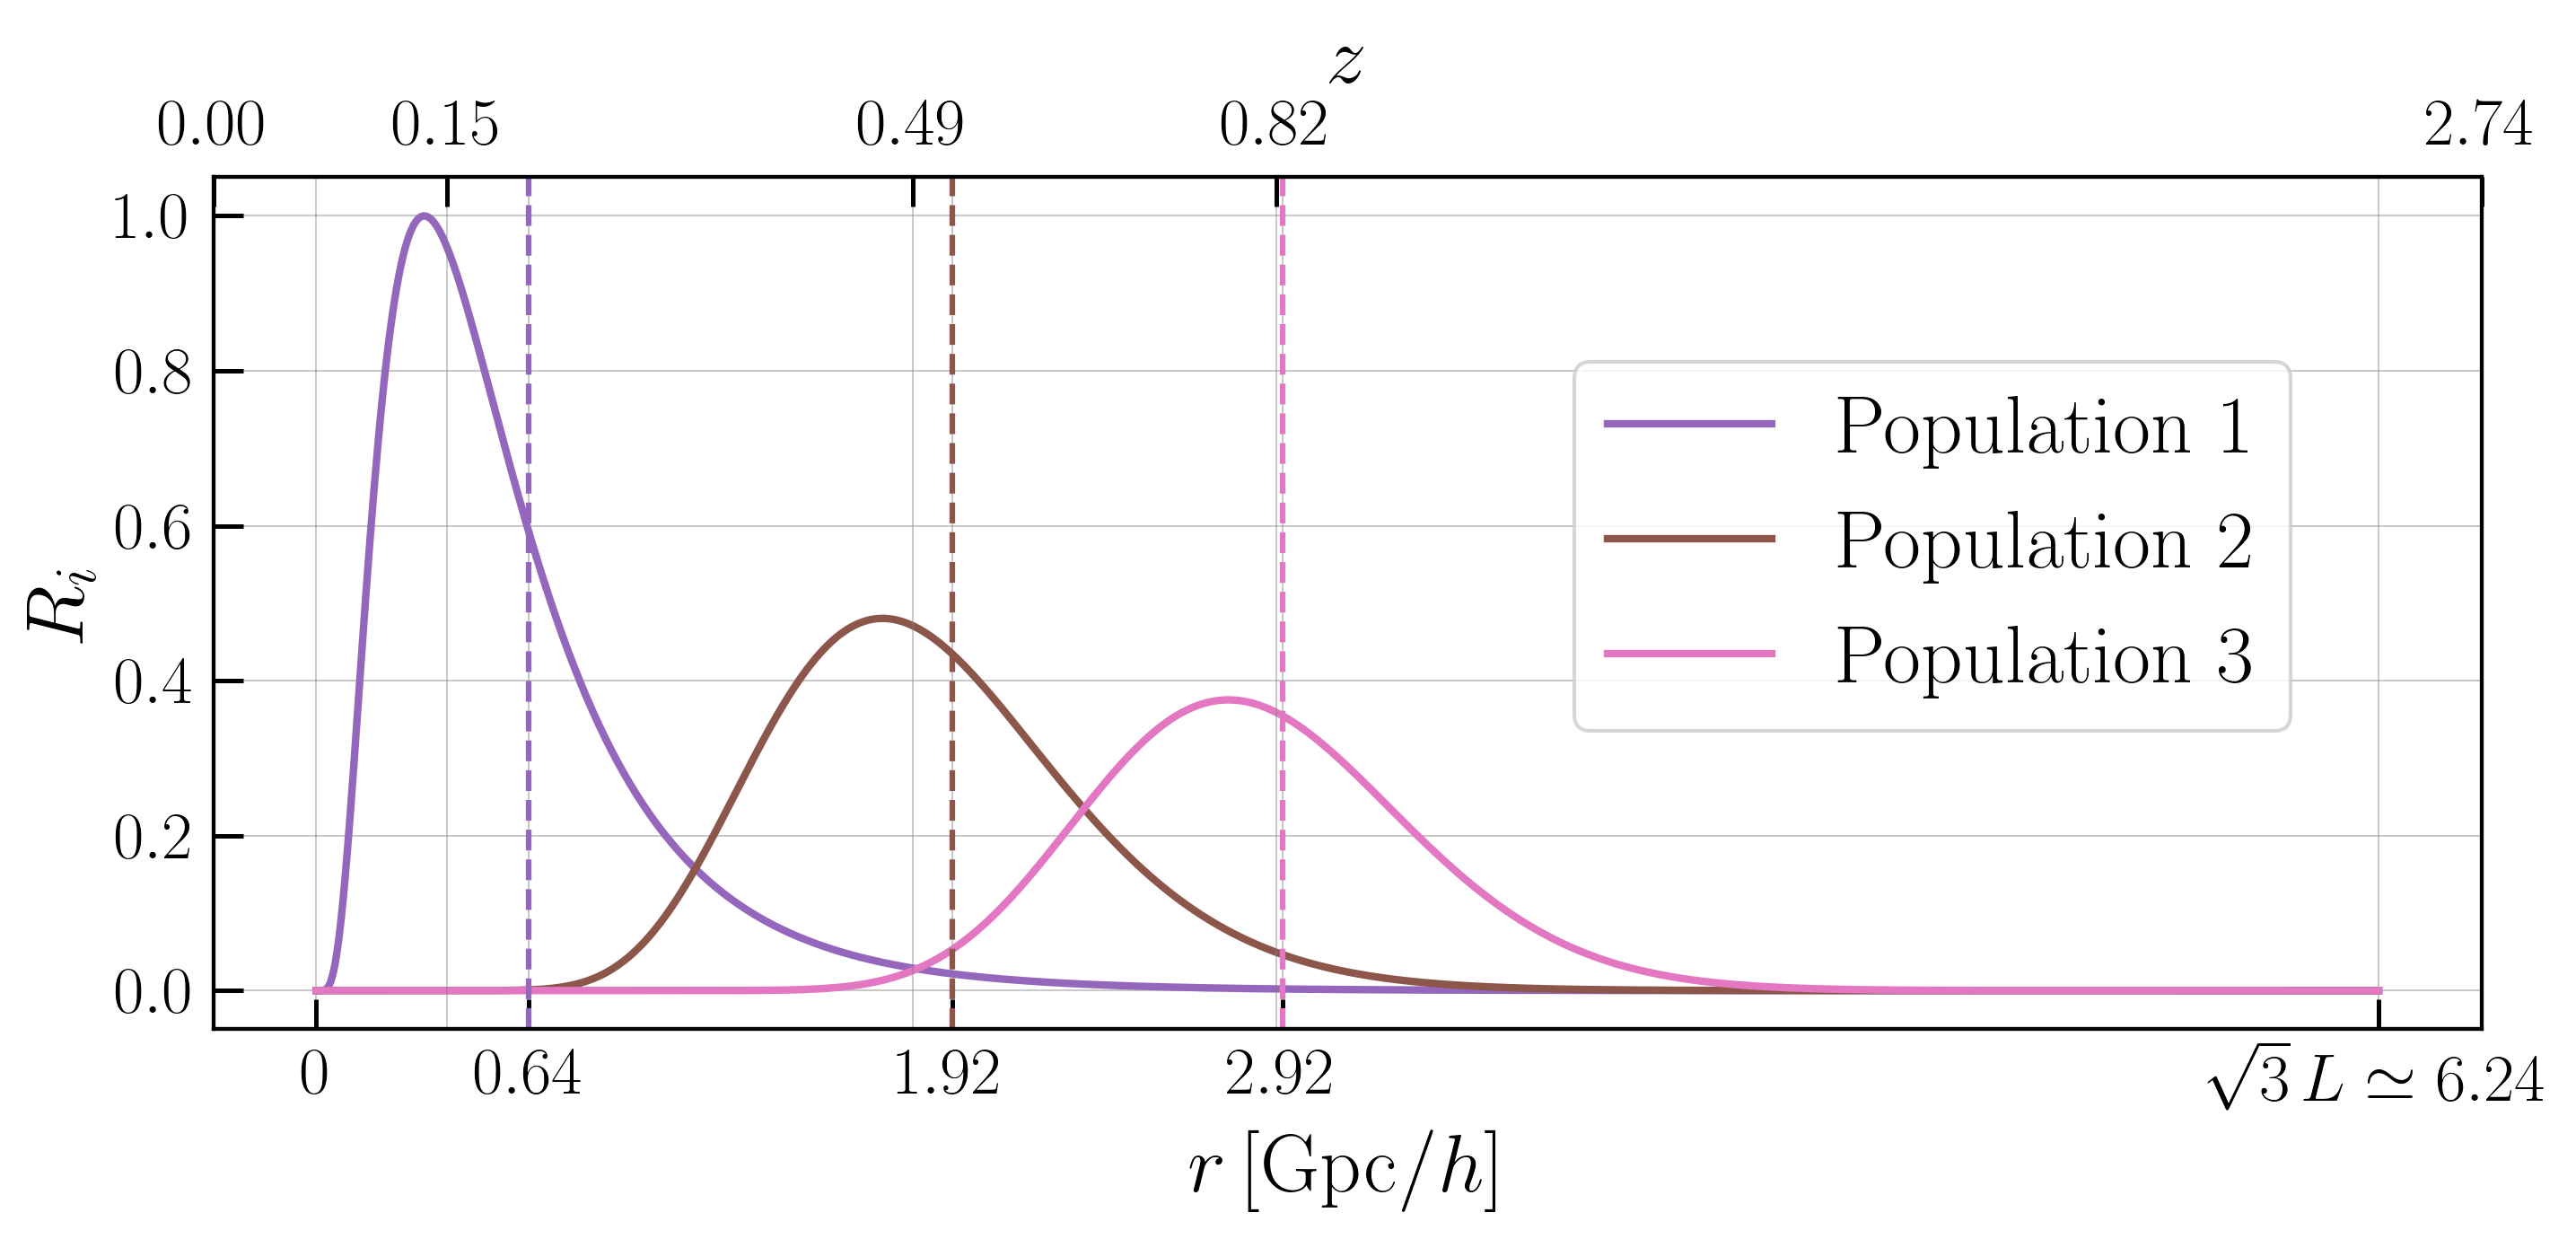

In [22]:
cste_z = 0.1
stds_z = np.array([cste_z * (1 + z) for z in z_means])
params = [stds_z, z_means, [1, 1, 1]]

zz, res = LogNorm.lognormals_z_to_x(xx, None, params, spline)

plot_selection_functions(
    xx,
    res,
    None,
    params,
    L,
    np.sqrt(3) * L,
    zz=zz,
    zcorner=z_corner,
)